Start of 6.7: Maximization Bias 2018-09-14 15:44:27.041680


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:24<00:00, 48.92it/s]



End of Maximization Bias 2018-09-14 15:51:48.321164
Running Time 0:07:21.279484


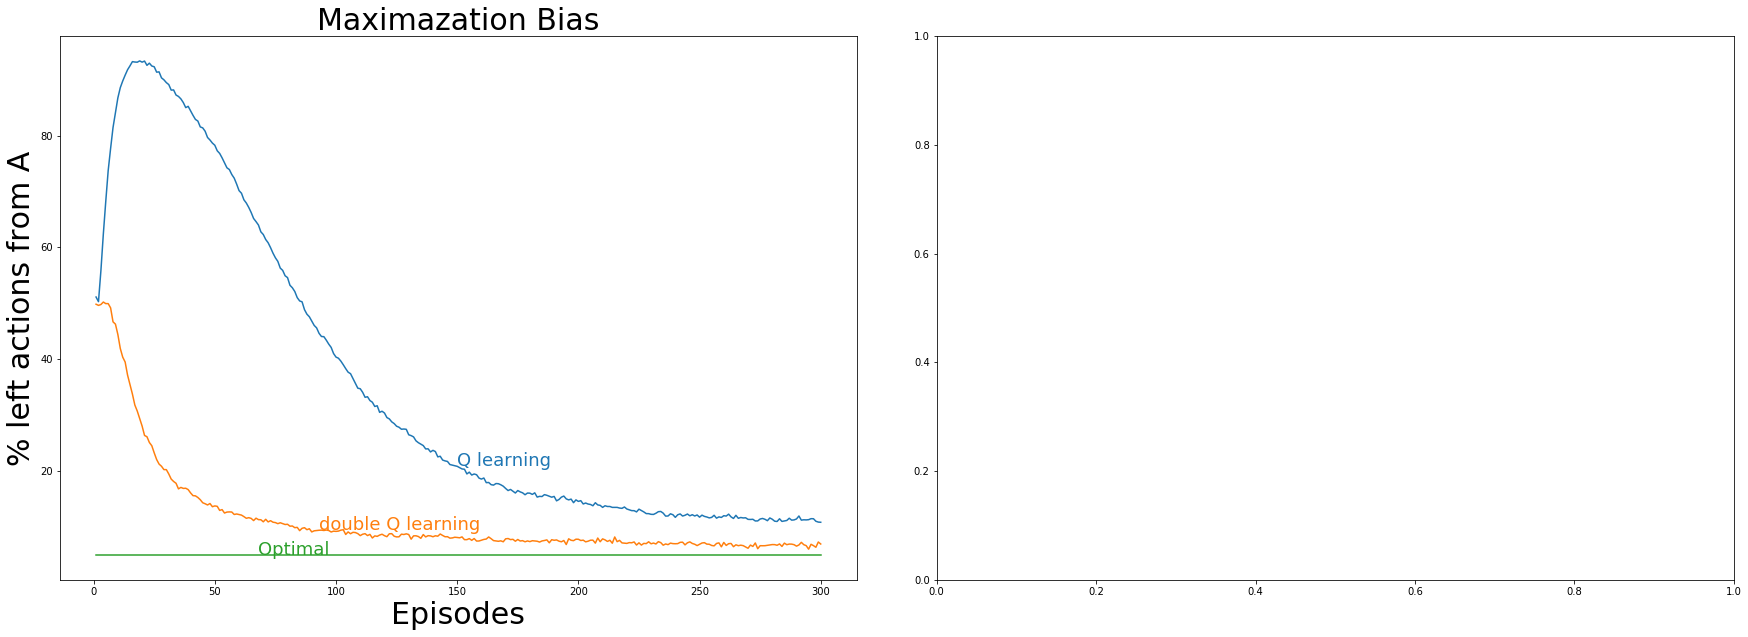

In [3]:
"""Example 6.7: Maximization Bias
Author : SeongJin Yoon
"""
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random
from tqdm import tqdm

class Action():
    left = 0
    right = 1
    left1 = 2
    left2 = 3
    left3 = 4
    left4 = 5
    left5 = 6
    left6 = 7
    left7 = 8
    left8 = 9
    left9 = 10
    left10 = 11
    
    @staticmethod
    def to_str(action):
        strlist = ["left", "right"]
        if action < 2:
            return strlist[action]
        return "left" + str(action-1)
    
    def to_char(action):
        strlist = ['L', 'R']
        if action < 2:
            return strlist[action]
        return "L" + str(action-1)
    
     
class MaximizationBias():
    def __init__(self):
        self.state_list = ['LM', 'B', 'A', 'RM']
        self.num_states = len(self.state_list)
        self.num_actions = 12
        self.start = 'A'
        self.start_idx = self.state_list.index(self.start)
        self.terminal = ['LM', 'RM']
        self.discount = 1
        self.epsilon = 0.1
        self.plot = Plot(nrows=1, ncols=2, figsize=(30,10))
    
    def init_q_value(self):
        q_value = np.zeros((self.num_states, self.num_actions))
        return q_value

    def get_reward(self, state_idx, action):
        
        reward = 0
        state = self.state_list[state_idx]       
        if state == 'B' :
            mu, sigma = -0.1, 1
            reward = np.random.normal(mu, sigma, 1)
        return reward
    
    def is_B_action(self, action):
        if action >=2:
            return True
        return False

    def is_terminal(self, state_idx):
        state = self.state_list[state_idx]
        if state in self.terminal :
            return True
        return False

    def get_random_action(self, state_idx):
        assert self.validate_state(state_idx)
        
        candidate = np.ones(self.num_actions)
        state = self.state_list[state_idx]
        if state == 'B':
            candidate[:2] = 0
            action = self.pick_best(candidate)
            if action < 2 :
                print(candidate)
                print(state, action, "random error")
        else:
            candidate[2:] = 0
            action = self.pick_best(candidate)
            if action >= 2 :
                print(candidate)
                print(state, action, "random error")
        
        return action

    def get_greedy_action(self, q_value, state_idx):        
        assert self.validate_state(state_idx)
        
        state = self.state_list[state_idx]
        if state == 'B':
            action = self.pick_best(q_value[state_idx, 2:-1])
            action += 2
            if action < 2 :
                print(q_value[state_idx, 2:])
                print(state, action, "greedy error")
                
        else:
            action = self.pick_best(q_value[state_idx, :2])
            if action >= 2 :
                print(q_value[state_idx, :2])
                print(state, action, "greedy error")
            
        return action

    def pick_best(self, candidate):
        max_list = np.argwhere(candidate[:] == np.max(candidate)).flatten()
        action = np.random.choice(max_list)
        return action

    def e_greedy_policy(self, q_value, state_idx):
        assert self.validate_state(state_idx)

        if np.random.binomial(1, self.epsilon) == 1:
            action = self.get_random_action(state_idx)
        else:
            action = self.get_greedy_action(q_value, state_idx)
            
        return action

    def validate_state(self, state_idx):
        if 0 <= state_idx < self.num_states:
            return True
        return False
    
    def do_action(self, state_idx, action):
        assert self.validate_state(state_idx)
        assert self.is_terminal(state_idx) is False
        
        # invalid action
        state = self.state_list[state_idx]
        if (state == 'B' and not self.is_B_action(action)) or \
            (state != 'B' and self.is_B_action(action)) :
            return state_idx, 0
        
        # valid action
        if action == Action.right:
            n_state_idx =  state_idx + 1
        else:
            n_state_idx =  state_idx - 1
            
        reward = self.get_reward(state_idx, action)

        return n_state_idx, reward
    
    def q_learning(self, q_value, alpha):
        # initial state
        state_idx = self.start_idx
        step = 1
        while self.is_terminal(state_idx) is False:
            action = self.e_greedy_policy(q_value, state_idx)
            
            # One step ahead
            n_state_idx, reward = self.do_action(state_idx, action)
            
            # Choose max action q value
            n_max_action = self.get_greedy_action(q_value, n_state_idx)

            # Q value update
            error = reward + self.discount*q_value[n_state_idx, n_max_action]\
                - q_value[state_idx, action]
                
            q_value[state_idx, action] += alpha*error
            state_idx = n_state_idx
            step += 1

        state = self.state_list[state_idx]
        return 1 if state == 'LM' else 0
    
    def double_q_learning(self, q_value1, q_value2, alpha):
        # initial state        
        state_idx = self.start_idx
        
        while self.is_terminal(state_idx) is False:
            action = self.e_greedy_policy(q_value1+q_value2, state_idx)
 
            # One step ahead
            n_state_idx, reward = self.do_action(state_idx, action)

            # Choose max action q value
            if np.random.binomial(1, 0.5) == 1:
                target_q, estimate_q = q_value1, q_value2
            else:
                target_q, estimate_q = q_value2, q_value1
                
            # Choose max action q value
            n_max_action = self.get_greedy_action(target_q, n_state_idx)

            # Q value update
            error = reward + self.discount*estimate_q[n_state_idx, n_max_action]\
                - target_q[state_idx, action]
            target_q[state_idx, action] += alpha*error
            
            state_idx = n_state_idx                
    
        state = self.state_list[state_idx]
        return 1 if state == 'LM' else 0
    
    def draw_6_7_plot(self):

        labels = ['Episodes', '% left actions from A', 'Maximazation Bias']
        
        ax = self.plot.draw_mline_begin(labels)
        self.draw_q_learning_plot(ax)
        self.draw_double_q_learning_plot(ax)
        self.draw_optimal_plot(ax)
        self.plot.draw_mline_end()
        
    def draw_q_learning_plot(self, ax):
        alpha = 0.1
        num_runs = 10000
        num_episode = 300
        left_rates = np.zeros(num_episode)

        for run in tqdm(range(num_runs)):
            q_value = self.init_q_value()
            for episode_idx in range(num_episode):
                # print("episode :", episode_idx)
                left_rates[episode_idx] += self.q_learning(q_value, alpha)
            
        left_rates = (left_rates/num_runs)*100
        episode_list = np.arange(1, num_episode + 1)
        label = "Q learning"
        self.plot.draw_mline(ax, episode_list, left_rates, label)
        
    def draw_double_q_learning_plot(self, ax):
        alpha = 0.1
        num_runs = 10000
        num_episode = 300
        left_rates = np.zeros(num_episode)

        for run in tqdm(range(num_runs)):
            q_value1 = self.init_q_value()
            q_value2 = self.init_q_value()
            for episode_idx in range(num_episode):
                left_rates[episode_idx] += \
                    self.double_q_learning(q_value1, q_value2, alpha)

        left_rates = (left_rates/num_runs)*100
        episode_list = np.arange(1, num_episode + 1)
        label = "double Q learning"
        self.plot.draw_mline(ax, episode_list, left_rates, label)


    def draw_optimal_plot(self, ax):
        num_episode = 300
        episode_list = np.arange(1, num_episode + 1)
        left_rates = np.full(num_episode, 5)
        label = "Optimal"
        self.plot.draw_mline(ax, episode_list, left_rates, label)
   
class Plot():
    def __init__(self, nrows, ncols, figsize):
        self.fig_idx = 0
        self.len_axes = nrows*ncols
        
        _, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        if self.len_axes != 1:
            self.axes = self.axes.flatten()

    def get_axes(self, idx):
        if self.len_axes != 1: 
            ax = self.axes[self.fig_idx]
        else:
            ax = self.axes
        return ax
    
    def draw_mline_begin(self, labels):       
        ax = self.get_axes(self.fig_idx)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        
        return ax
        
    def draw_mline(self, ax, pos, data, label, linestyle='solid'):
        lines = ax.plot(pos, data, label=label, linestyle=linestyle)
        
        pivot_idx = random.randint(0, (len(data)*2)//3)
        x_pos = pos[pivot_idx]
        y_pos = data[pivot_idx]
        ax.text(x_pos, y_pos, label, color = lines[0].get_color(), size=18)

    def draw_mline_end(self):       
        self.fig_idx += 1

    def draw_bar(self, pos, data, labels):
        ax = self.get_axes(self.fig_idx)
        ax.bar(pos, data)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    def draw_table(self, data):
        ax = self.get_axes(self.fig_idx)
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])
        tb.auto_set_font_size(value=False)
        tb.set_fontsize(20)
        HEIGHT, WIDTH = data.shape
        for row in range(HEIGHT):
            for col in range(WIDTH):
                val = data[row, col]
                width, height = 1.0 / WIDTH, 1.0 / HEIGHT
                tb.add_cell(row, col, height, width,
                            text=val, loc='center', facecolor='white')

        ax.add_table(tb)
        self.fig_idx += 1
        
    def show(self):
        plt.show()
  
if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Start of 6.7: Maximization Bias", begin_time)
    max_bias = MaximizationBias()
    max_bias.draw_6_7_plot()
    end_time = dt.datetime.now()
    print()
    print("End of Maximization Bias", end_time)
    print("Running Time", end_time - begin_time)